In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
model = 'random_waypoint'
method = 'mean'

df_eval = pd.concat([
    pd.read_csv(f'evaluate/evaluate_{model}_{i}.csv')
    for i in range(20, 30)
])

In [3]:
df_eval.columns

Index(['velocity', 'towers', 'users', 'accuracy', 'accuracy_std', 'error',
       'error_std', 'recover_time', 'map_time', 'execution_time'],
      dtype='object')

In [4]:
len(df_eval)

1440

In [5]:
df_eval = getattr(df_eval.groupby(['velocity', 'towers', 'users']), method)().reset_index()

In [6]:
df_eval.accuracy.describe()

count    144.000000
mean       0.305203
std        0.223806
min        0.079365
25%        0.139648
50%        0.206499
75%        0.409694
max        0.932344
Name: accuracy, dtype: float64

In [7]:
df_eval.velocity.unique()

array(['(0.01, 0.01)', '(0.05, 0.05)', '(0.1, 0.1)'], dtype=object)

In [8]:
def plot_heatmap(vel_restriction, metric='accuracy', ax=None, vmin=None, vmax=None, cbar=True, title='', cmap=None):
    df = df_eval[df_eval.velocity == vel_restriction]

    df = df.sort_values(['towers', 'users'], ascending=[False, True])
    
    n_tower_values = len(df.towers.unique())
    n_users_values = len(df.users.unique())

    sns.heatmap(
        df[metric].as_matrix().reshape((n_tower_values, n_users_values)),
        ax=ax,
        xticklabels=df['users'].unique(),
        yticklabels=df['towers'].unique(),
        vmax=vmax,
        vmin=vmin,
        cbar=cbar,
        cmap=cmap,
        square=True,
        fmt=".2f",
        annot=True,
    )
    
    ax.set(xlabel='# Users', ylabel='# Towers')
#     ax.set_title(title, pad=12)

# Accuracy and error analysis

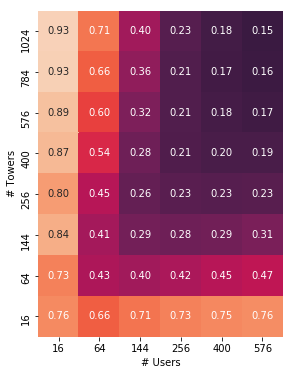

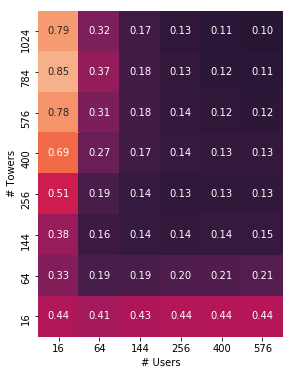

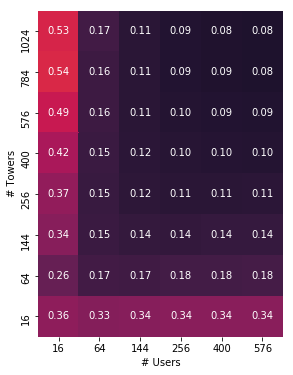

In [9]:
for i, vel in enumerate(df_eval.velocity.unique()):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(
        vel_restriction=vel,
        title=f'Velocity {vel}',
        metric='accuracy',
        ax=axes,
        vmin=0,
        vmax=1,
        cbar=False)

    plt.savefig(f'./accuracy_{model}_{vel}.png', dpi=300)

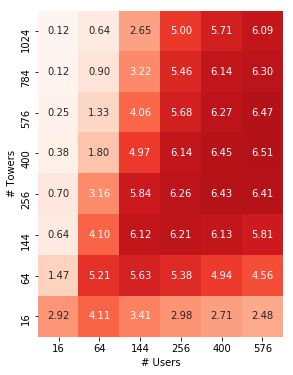

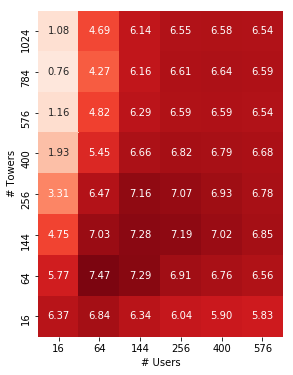

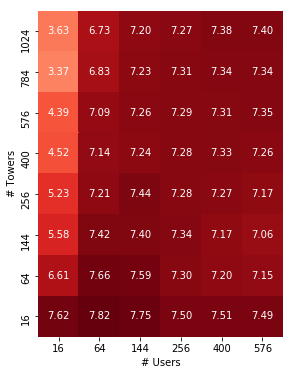

In [10]:
for i, vel in enumerate(df_eval.velocity.unique()):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(
        vel_restriction=vel,
        metric='error',
        ax=axes,
        title=f'Velocity {vel}',
        cbar=False,
        cmap='Reds',
        vmin=df_eval.error.min(),
        vmax=df_eval.error.max(),
    )

    plt.savefig(f'./error_{model}_{vel}.png', dpi=300)

# Execution time analysis

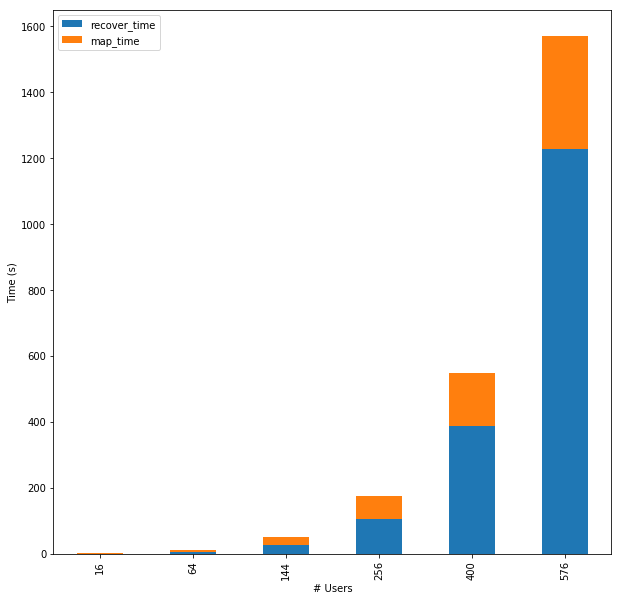

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

df_eval.groupby(['users']).mean()[[
        'recover_time',
        'map_time',
#         'execution_time',
]].plot.bar(ax=ax, stacked=True)

ax.set(xlabel="# Users", ylabel="Time (s)")
plt.savefig(f'./execution_time.png', dpi=300)

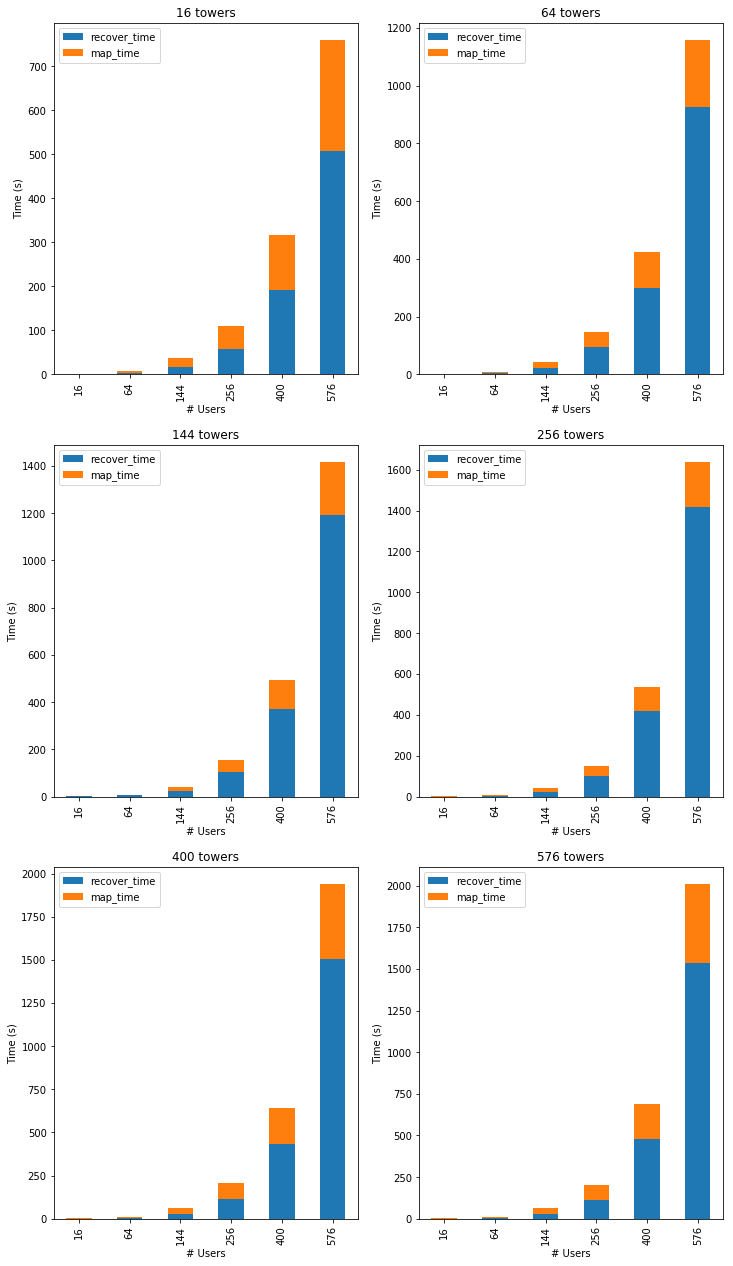

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 22))
axes = axes.flatten()

for ax, t in zip(axes, df_eval.towers.unique()):
    df_eval[df_eval.towers == t].groupby(['users']).mean()[[
        'recover_time',
        'map_time',
#         'execution_time',
    ]].plot.bar(ax=ax, stacked=True)
    ax.set_title(f'{t} towers')
    ax.set(xlabel='# Users', ylabel='Time (s)')

plt.savefig(f'./execution_time_by_towers.png', dpi=300)